# Assignment 6: Viola&Jones
Read the paper by Viola and Jones. You can find it in "mycampus/resources/papers".

## Ex. 5.1 Rectangular Features
Implement the construction of all 2-rect features (horizontal and vertical) within a given window (like the 24x24 px window from the paper). How many exist? **(RESULT)** Display three of these overlaid onto an image of a face. **(RESULT)**

## Ex. 5.2 Integral Image 
Implement a function that computes the integral image of a given input image. Display the integral image for an input of you choice **(RESULT)**. Compare it to the output of skimage's integral_image() function. **(RESULT)**

Are the 2 integral images equal? True


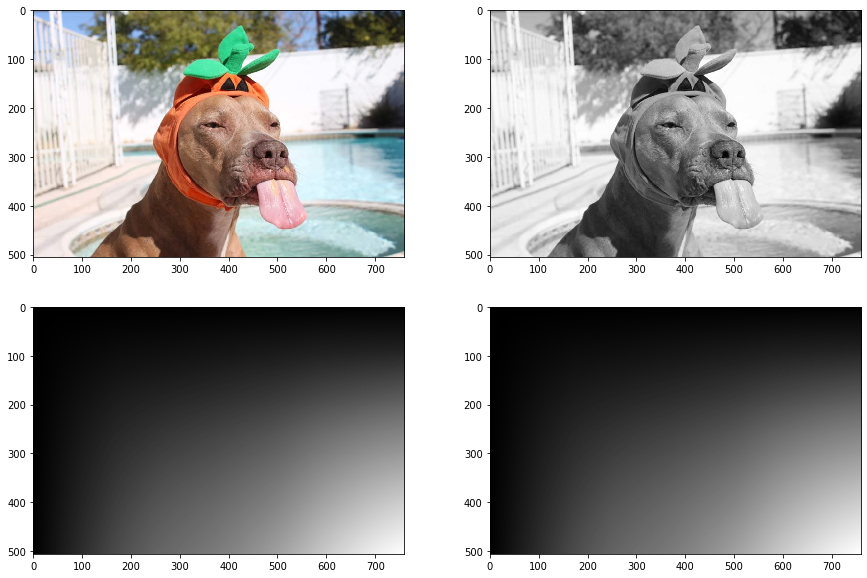

In [15]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
from skimage import color, io, transform


input_image = io.imread("images/dog.jpg")
input_image_gray = color.rgb2gray(input_image)

def integral_image(img):
    h, w = shape = img.shape
    # Make matrices bigger so we don't have to have if-else for s(x, -1) = 0 and ii(-1, y) = 0
    # In the end, we just ignore those extra row and column to get back the original size.
    s = np.zeros((h + 1, w + 1))
    ii = np.zeros((h + 1, w + 1))
    for y in range(1, h + 1):
        for x in range(1, w + 1):
            s[y, x] = s[y - 1, x] + img[y - 1, x - 1]
            ii[y, x] = ii[y, x - 1] + s[y, x]
    return ii[1:, 1:]


ii_self = integral_image(input_image_gray)
ii_skimage = transform.integral_image(input_image_gray)

print('Are the 2 integral images equal?', 'Yes.' if np.all(ii_self == ii_skimage) else 'No.')


fig = plt.figure(figsize=(15, 10))
ax11 = plt.subplot(2, 2, 1)
ax12 = plt.subplot(2, 2, 2)
ax21 = plt.subplot(2, 2, 3)
ax22 = plt.subplot(2, 2, 4)

ax11.imshow(input_image)
ax12.imshow(input_image_gray, cmap='gray')
ax21.imshow(ii_self, cmap='gray')
ax22.imshow(ii_skimage, cmap='gray')


None

# Ex. 5.3 AdaBoosting
Implement the AdaBoost algorithm as outlined in the paper. Train a 20-feature classifier using these datasets: 
    
faces and non-faces:    www.ai.mit.edu/courses/6.899/lectures/faces.tar.gz

Test your classifier with different thesholds and visualize the ROC curve **(RESULTS)**